In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from src.preprocessing import load_and_clean_data
from src.abc_analysis import abc_analysis
from src.market_basket import run_market_basket_analysis

In [2]:
df = load_and_clean_data('../data/bakery_sales.csv')

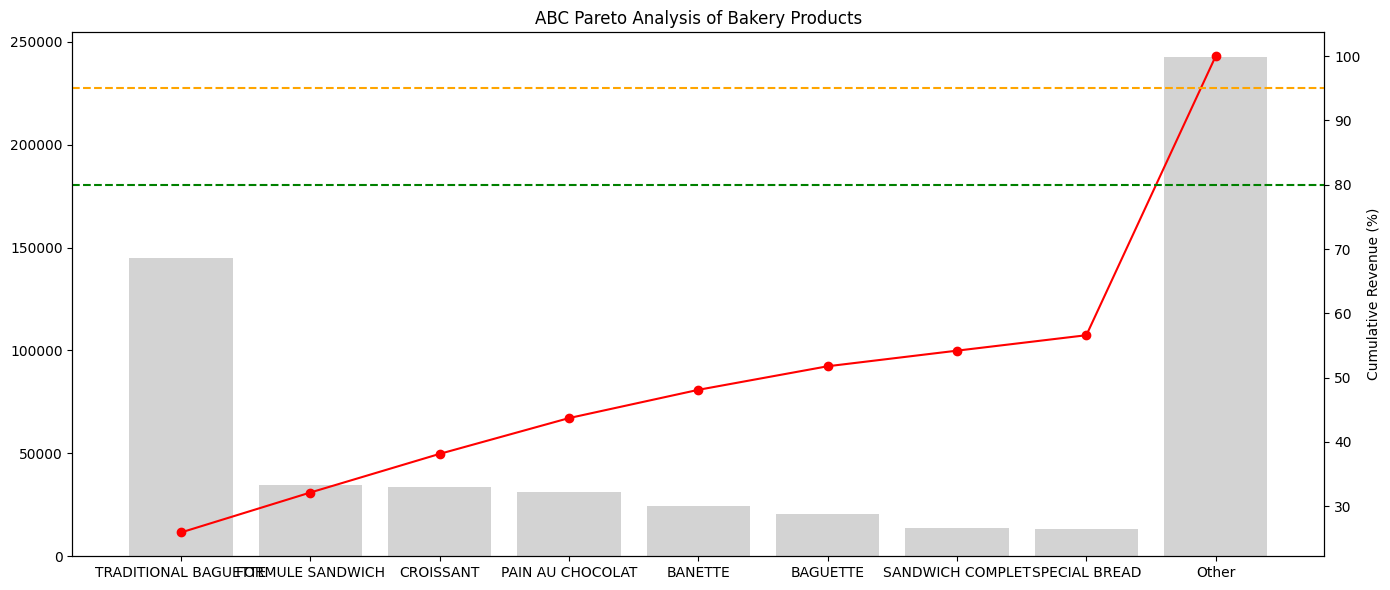

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

abc_df = abc_analysis(df)

# Take top 8 items 
top_n = 8
top_items = abc_df.head(top_n)
others_revenue = abc_df['revenue'][top_n:].sum()
others_cum = 100 

# DataFrame for "Other"
other_df = pd.DataFrame({'revenue': [others_revenue],
                         'cumulative_pct': [others_cum]},
                        index=['Other'])

top_items = pd.concat([top_items, other_df])


plt.figure(figsize=(14,6))

plt.bar(top_items.index, top_items['revenue'], color='lightgray')

plt.twinx()
plt.plot(top_items.index, top_items['cumulative_pct'], color='red', marker='o')
plt.axhline(80, color='green', linestyle='--', label='A threshold (80%)')
plt.axhline(95, color='orange', linestyle='--', label='B threshold (95%)')

plt.xticks(rotation=45, ha='right')
plt.ylabel("Cumulative Revenue (%)")
plt.title("ABC Pareto Analysis of Bakery Products")
plt.tight_layout()
plt.savefig("../figures/abc_pareto.png")
plt.show()


In [4]:
A_items = abc_df[abc_df['ABC_class'] == 'A']
A_items['revenue_pct'] = A_items['revenue'] / abc_df['revenue'].sum() * 100

print("A-Tier Products (High-Control Items):")
print(A_items[['revenue', 'revenue_pct']])


A-Tier Products (High-Control Items):
                        revenue  revenue_pct
article                                     
TRADITIONAL BAGUETTE  144756.05    25.912185
FORMULE SANDWICH       34710.50     6.213384
CROISSANT              33579.50     6.010928
PAIN AU CHOCOLAT       31100.45     5.567164
BANETTE                24555.15     4.395516
BAGUETTE               20481.40     3.666291
SANDWICH COMPLET       13550.00     2.425530
SPECIAL BREAD          13419.70     2.402205
TRAITEUR               12254.30     2.193592
GRAND FAR BRETON       10713.50     1.917780
TARTELETTE             10333.80     1.849811
CEREAL BAGUETTE         9473.40     1.695794
VIK BREAD               9278.60     1.660924
BRIOCHE                 9222.00     1.650792
CAMPAGNE                8092.30     1.448569
GD KOUIGN AMANN         8064.00     1.443503
BOULE 400G              7532.90     1.348433
ECLAIR                  7505.60     1.343547
MOISSON                 6915.00     1.237826
SAND JB EMMENTAL 

C:\Users\serap\AppData\Local\Temp\ipykernel_26568\711588773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_items['revenue_pct'] = A_items['revenue'] / abc_df['revenue'].sum() * 100


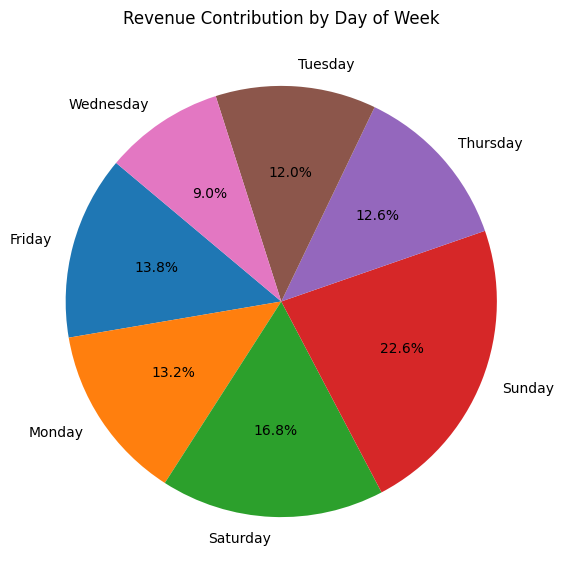

In [5]:
df['day'] = df['date'].dt.day_name()
day_rev = df.groupby('day')['revenue'].sum()
day_pct = day_rev / day_rev.sum() * 100

plt.figure(figsize=(7,7))
plt.pie(day_pct, labels=day_pct.index, autopct='%1.1f%%', startangle=140)
plt.title("Revenue Contribution by Day of Week")
plt.savefig("../figures/revenue_by_day.png")
plt.show()


C:\Users\serap\AppData\Local\Temp\ipykernel_26568\2954519447.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['time'].astype(str)).dt.hour


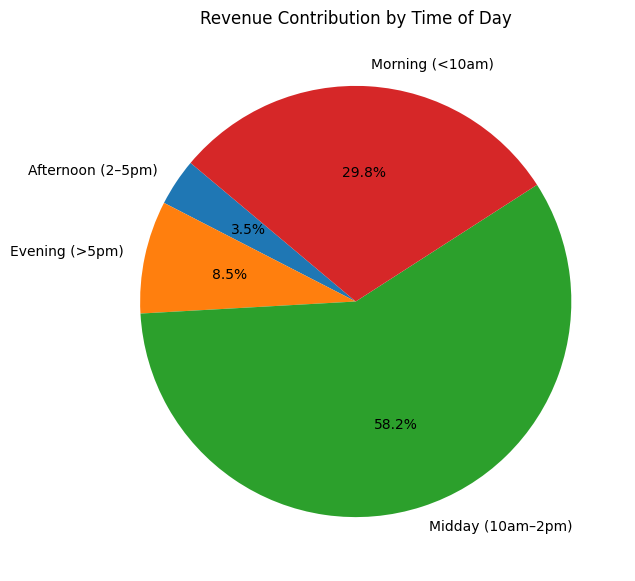

In [6]:
def time_bucket(hour):
    if hour < 10:
        return "Morning (<10am)"
    elif hour < 14:
        return "Midday (10am–2pm)"
    elif hour < 17:
        return "Afternoon (2–5pm)"
    else:
        return "Evening (>5pm)"

df['hour'] = pd.to_datetime(df['time'].astype(str)).dt.hour
df['time_bucket'] = df['hour'].apply(time_bucket)

time_rev = df.groupby('time_bucket')['revenue'].sum()
time_pct = time_rev / time_rev.sum() * 100

plt.figure(figsize=(7,7))
plt.pie(time_pct, labels=time_pct.index, autopct='%1.1f%%', startangle=140)
plt.title("Revenue Contribution by Time of Day")
plt.savefig("../figures/revenue_by_time.png")
plt.show()


In [7]:
df['is_sunday_morning'] = (
    (df['day'] == 'Sunday') & (df['hour'] < 10)
)

df['is_weekday_lunch'] = (
    (df['day'].isin(['Tuesday','Wednesday','Thursday'])) &
    (df['hour'].between(11,13))
)
from itertools import combinations
from collections import defaultdict

def co_occurrence_by_subset(df_subset):
    basket = df_subset.groupby('ticket_number')['article'].apply(set)

    pair_counts = defaultdict(int)
    item_counts = defaultdict(int)

    for items in basket:
        for item in items:
            item_counts[item] += 1
        for a,b in combinations(items,2):
            pair_counts[(a,b)] += 1

    results = []
    for (a,b), cnt in pair_counts.items():
        prob = cnt / min(item_counts[a], item_counts[b])
        results.append((a,b,prob))

    return pd.DataFrame(results, columns=['Item1','Item2','CoProb'])
sunday_rules = co_occurrence_by_subset(df[df['is_sunday_morning']])
lunch_rules = co_occurrence_by_subset(df[df['is_weekday_lunch']])

diff = sunday_rules.merge(
    lunch_rules,
    on=['Item1','Item2'],
    how='outer',
    suffixes=('_sunday','_lunch')
).fillna(0)

diff['delta'] = diff['CoProb_sunday'] - diff['CoProb_lunch']
valid_items = abc_df[abc_df['ABC_class'].isin(['A','B'])].index

bundles = diff[
    (diff['Item1'].isin(valid_items)) &
    (diff['Item2'].isin(valid_items)) &
    (diff['CoProb_sunday'] > 0.5)
]

print("Time-Specific Bundle Suggestions:")
print(bundles.sort_values('CoProb_sunday', ascending=False).head(10))


Time-Specific Bundle Suggestions:
                     Item1                 Item2  CoProb_sunday  CoProb_lunch  \
2425                SEIGLE  TRADITIONAL BAGUETTE       0.706897      0.436620   
2918             VIK BREAD                 COUPE       0.625442      0.716157   
2800  TRADITIONAL BAGUETTE     TARTE FRAISE 4PER       0.611111      1.000000   
2713  TRADITIONAL BAGUETTE               BRIOCHE       0.602996      0.487805   
2777  TRADITIONAL BAGUETTE            PLAT 7.60E       0.600000      0.181818   
2839              TRAITEUR      PAIN AU CHOCOLAT       0.583333      0.002577   
2967             VIK BREAD  TRADITIONAL BAGUETTE       0.583039      0.580786   
620                  COUPE            BOULE 200G       0.575630      0.498542   
1893      PAIN AUX RAISINS      PAIN AU CHOCOLAT       0.569767      0.187500   
253             BOULE 400G                 COUPE       0.564263      0.656687   

         delta  
2425  0.270277  
2918 -0.090716  
2800 -0.388889  
2713  

In [8]:
substitutes = diff[
    (diff['CoProb_sunday'] < 0.05) &
    (diff['CoProb_lunch'] < 0.05)
]

# Only flag if one or both are C-tier
c_items = abc_df[abc_df['ABC_class'] == 'C'].index

substitutes = substitutes[
    substitutes['Item1'].isin(c_items) |
    substitutes['Item2'].isin(c_items)
]

print("Potential Cannibalization Candidates:")
print(substitutes[['Item1','Item2','CoProb_sunday','CoProb_lunch']].head(10))


Potential Cannibalization Candidates:
               Item1               Item2  CoProb_sunday  CoProb_lunch
23          BAGUETTE         BOULE POLKA       0.030303      0.015873
33          BAGUETTE       DEMI BAGUETTE       0.011765      0.000000
60          BAGUETTE             SAVARIN       0.020833      0.000000
70          BAGUETTE           TRIANGLES       0.000000      0.025641
73    BAGUETTE APERO        BOISSON 33CL       0.000000      0.047619
74    BAGUETTE APERO    SAND JB EMMENTAL       0.000000      0.047619
88   BAGUETTE GRAINE  DIVERS BOULANGERIE       0.000000      0.041667
100  BAGUETTE GRAINE      NOIX JAPONAISE       0.033333      0.000000
105  BAGUETTE GRAINE        PALET BRETON       0.000000      0.037037
113  BAGUETTE GRAINE             SUCETTE       0.043478      0.000000


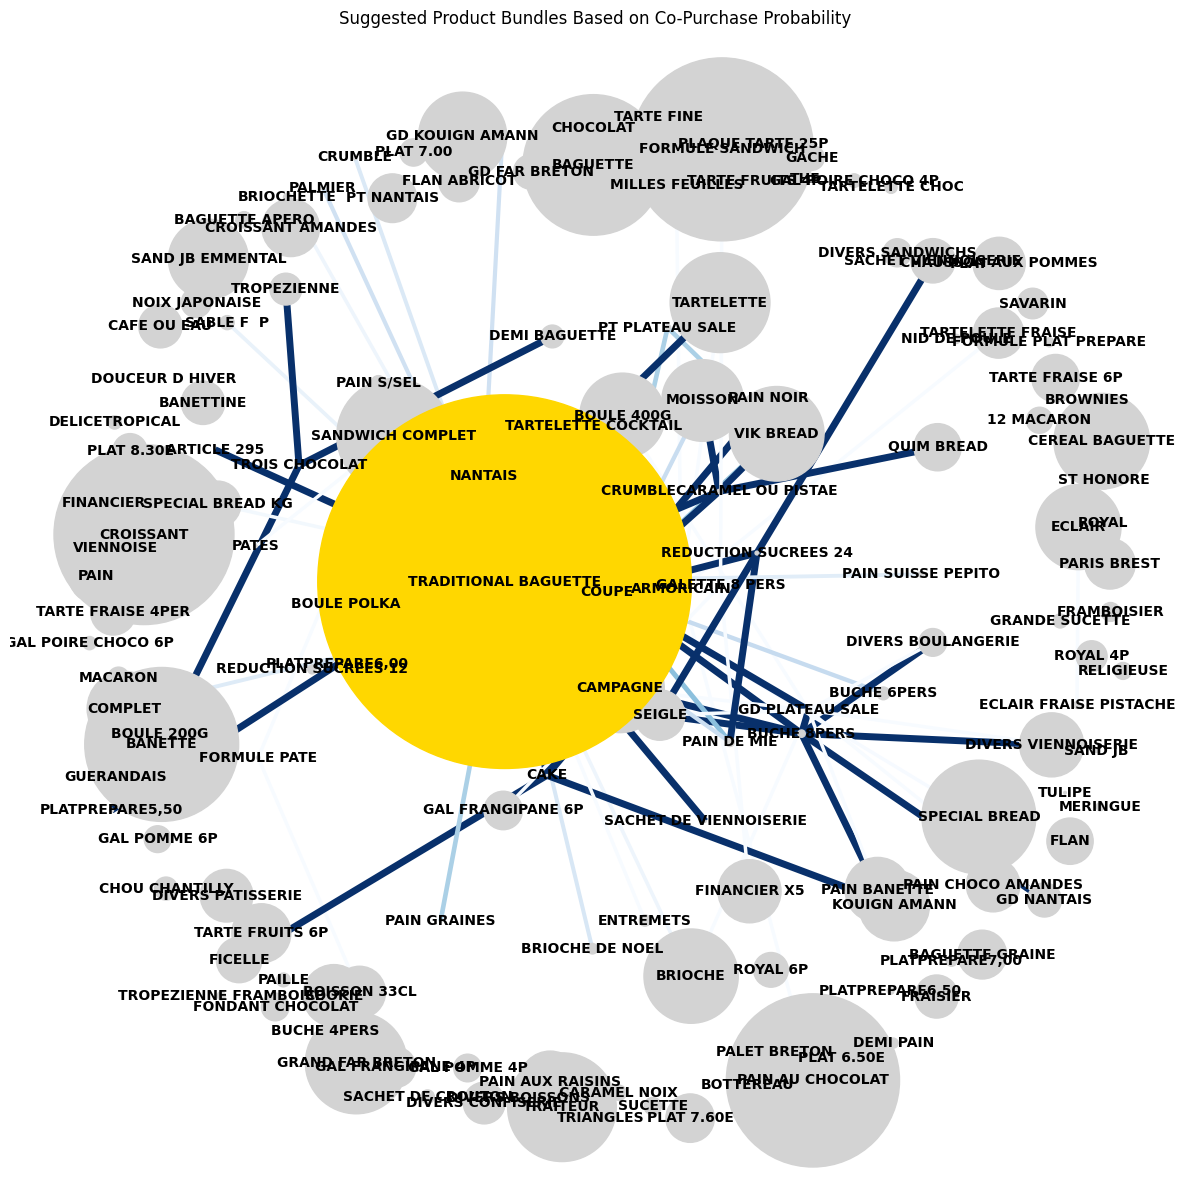

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import pandas as pd
from src.preprocessing import load_and_clean_data

# Load data
df = load_and_clean_data('../data/bakery_sales.csv')
df['revenue'] = df['quantity'] * df['unit_price']

# Prepare basket per ticket
basket = df.groupby('ticket_number')['article'].apply(list)

# Count pair occurrences
pair_counts = {}
item_counts = {}

for items in basket:
    unique_items = list(set(items))
    for item in unique_items:
        item_counts[item] = item_counts.get(item, 0) + 1
    for pair in combinations(unique_items, 2):
        pair_counts[pair] = pair_counts.get(pair, 0) + 1

# Co-occurrence probability
co_occurrence = {}
for (item1, item2), count in pair_counts.items():
    co_occurrence[(item1, item2)] = count / min(item_counts[item1], item_counts[item2])

# Create network graph for high co-occurrence bundles
threshold = 0.5  # only show strong bundles
G = nx.Graph()

# Node sizes by total revenue
revenue_by_item = df.groupby('article')['revenue'].sum()

# Optional: ABC tiering for node colors
def assign_tier(pct):
    if pct >= 25:
        return 'S'
    elif pct >= 15:
        return 'A'
    elif pct >= 10:
        return 'B'
    else:
        return 'C'

total_revenue = revenue_by_item.sum()
tier_colors = {'S':'gold', 'A':'skyblue', 'B':'lightgreen', 'C':'lightgrey'}
tiers = (revenue_by_item / total_revenue * 100).apply(assign_tier)

# Add nodes
for item in revenue_by_item.index:
    G.add_node(item, size=revenue_by_item[item], color=tier_colors[tiers[item]])

# Add edges for strong co-occurrences
for (item1, item2), prob in co_occurrence.items():
    if prob >= threshold:
        G.add_edge(item1, item2, weight=prob)

# Draw network
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.5, seed=42)

# Node sizes and colors
node_sizes = [G.nodes[n]['size']*0.5 for n in G.nodes]  # scale down for plotting
node_colors = [G.nodes[n]['color'] for n in G.nodes]

# Edge widths proportional to co-occurrence
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w*5 for w in weights], edge_color=weights, edge_cmap=plt.cm.Blues)

plt.title('Suggested Product Bundles Based on Co-Purchase Probability')
plt.axis('off')
plt.tight_layout()
plt.savefig('../figures/bundle_network_graph.png')
plt.show()
